# Imports

In [145]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("data/bokeh_output.html")
from qgrid import show_grid
# import finplot as fplt

import polygon_rest_api as papi
import polygon_ws_api as pws
import polygon_df as pdf
import polygon_ds as pds
import polygon_s3 as ps3
import bar_samples as bs
import bar_labels as bl
import ray_bars as bm
import utils_filters as ft
import flow_backfill as fb
# import ray_backfill as rb
# import market_cluster as mc

import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

# import ipdb
# ipdb.set_trace(context=10)

# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG' are other good diverging colormaps
# pd.set_option('precision', 2)

# .plot_bokeh(sizing_mode="scale_height")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Backfill Data

In [ ]:
clust_symbols = ['AG', 'AXU', 'BVN', 'CDE', 'EXK', 'FSM', 'GORO', 'GSS', 'HL', 'MAG', 'MUX', 'PVG', 'SVM', 'USAS']

all_sym = clust_symbols + ['VTI', 'GLD']

In [ ]:
fb.run_flow(
    symbols=all_sym,
    tick_type='trades', 
    start_date='2019-01-01', 
    n_workers=2, 
    threads_per_worker=4
)

# Sample Ticks

In [96]:
symbol = 'VTI'
start_date = '2020-11-01'
end_date = '2020-11-31'
date = '2020-11-13'

ticks_df = ps3.fetch_date_df(symbol, date, tick_type='trades')
daily_df = bm.get_symbol_vol_filter(symbol, start_date, end_date)

In [225]:
rs = daily_df[daily_df.date == date]['range_jma_lag'].values[0] / 30

thresh = {
    # max thresholds
    'renko_size': rs,
    'renko_return': 'jma_return',
    'renko_reveral_multiple': 2,
    'max_duration_sec': 60*60*2,  # 2hours
    
    # min thresholds
    'min_duration_sec': 15,
    'min_tick_count': 30,
}

# sample bars
bars, ticks = bs.build_bars(ticks_df, thresh)

ticks2_df = pd.DataFrame(ticks)
bars_df = pd.DataFrame(bars)

ticks2_df.status.value_counts()

clean                       26646
irregular_tick_condition      170
timestamp_diff                 98
filter_outlier                 61
filter_warm_up                  7
zero_volume                     3
Name: status, dtype: int64

In [200]:
bars_df.duration_td.describe(percentiles=[.01,.1,.8,.95])

count                           60
mean     0 days 00:11:12.960344354
std      0 days 00:18:38.683039157
min      0 days 00:00:16.238855936
1%       0 days 00:00:18.536488046
10%      0 days 00:00:32.764256691
50%      0 days 00:05:22.478914432
80%      0 days 00:12:03.923588915
95%      0 days 00:42:54.615671334
max      0 days 01:48:27.388091136
Name: duration_td, dtype: object

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

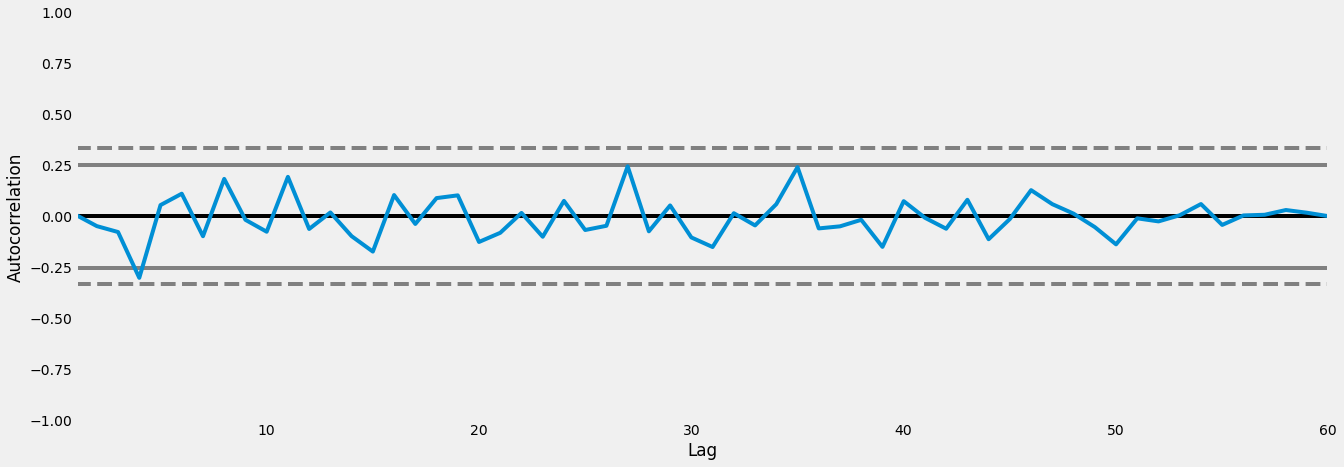

In [355]:
s2 = bars_df.jma_return

pd.plotting.autocorrelation_plot(s2)

<AxesSubplot:>

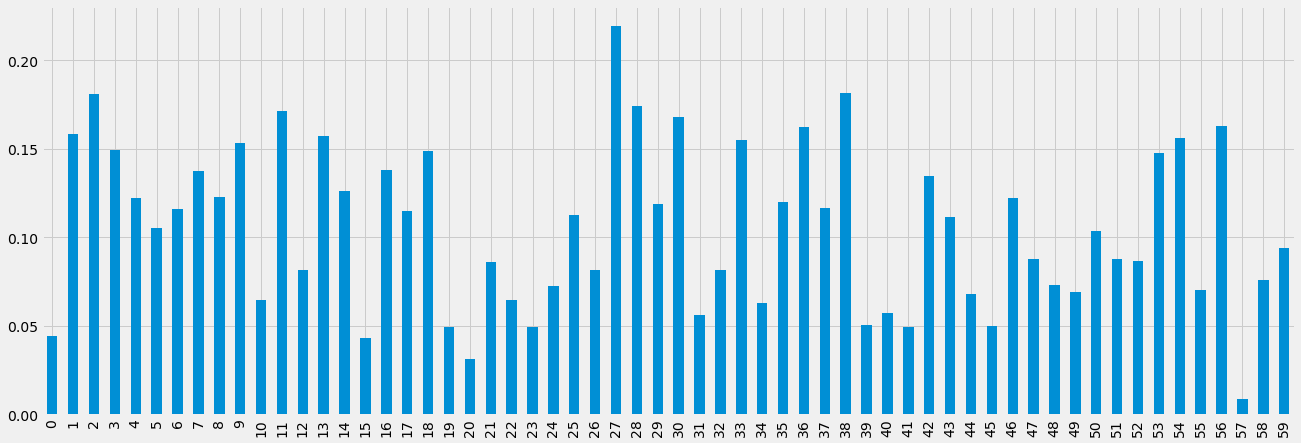

In [247]:
(bars_df.jma_wq90-bars_df.jma_wq10).plot.bar()

<AxesSubplot:>

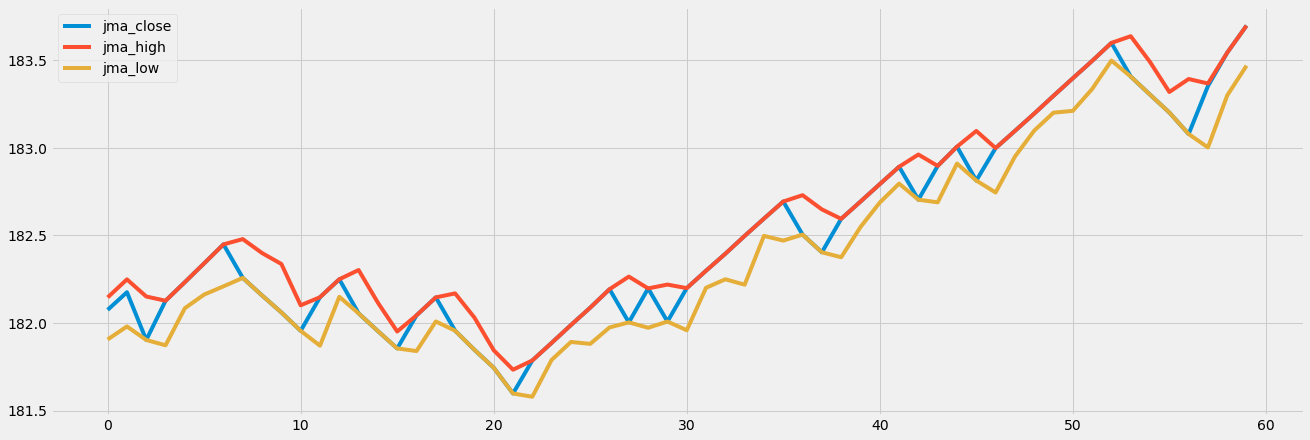

In [239]:
bars_df[['jma_close','jma_high','jma_low']].plot()
# plot_bokeh(sizing_mode="scale_height")

<AxesSubplot:xlabel='date_time'>

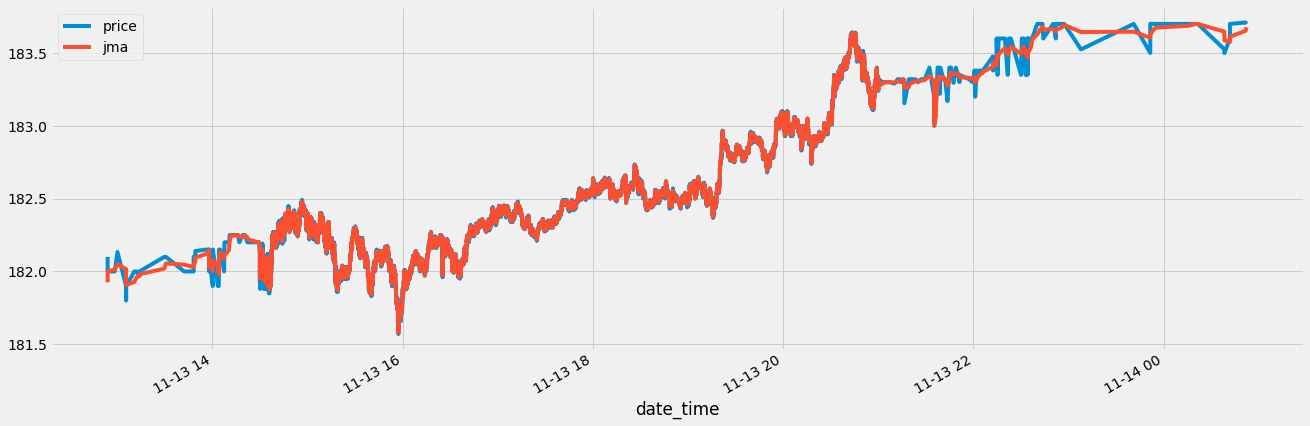

In [152]:
ticks2_df[ticks2_df.status=='clean'].set_index('date_time').loc[:, ['price', 'jma']].plot()

<AxesSubplot:>

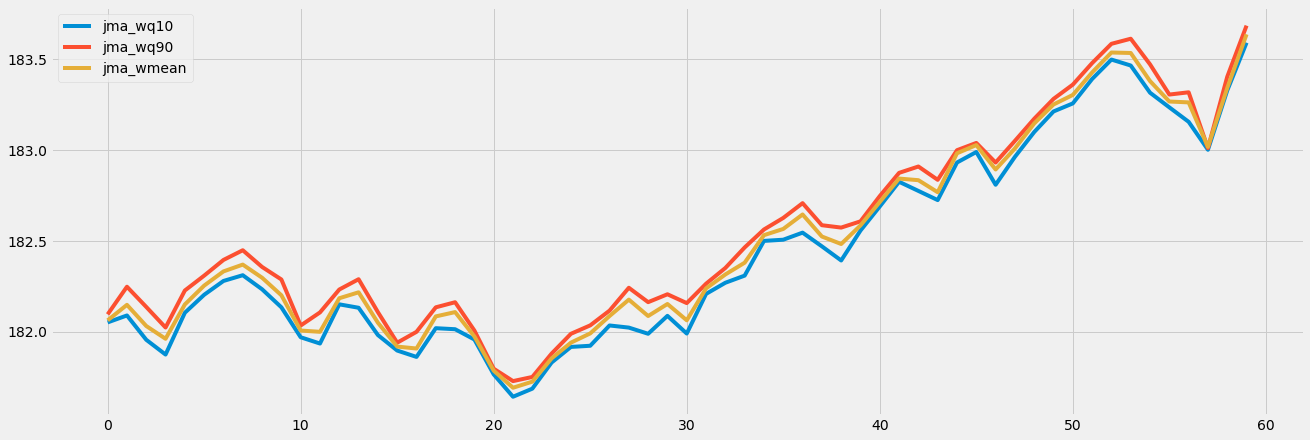

In [335]:
bars_df[['jma_wq10', 'jma_wq90', 'jma_wmean']].plot()

<AxesSubplot:>

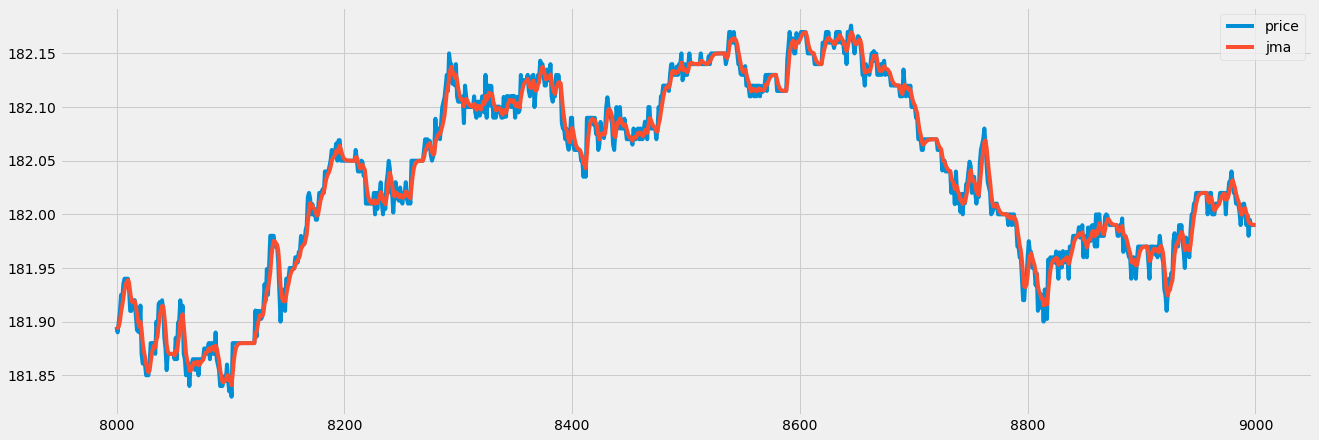

In [188]:
ixs += 1000
# ixs = 0
ixe = ixs+1000

ticks2_df[ticks2_df.status=='clean'].loc[ixs:ixe, ['price', 'jma']].plot()

# ticks2_df[['price', 'jma']][ixs:ixe].plot()

<AxesSubplot:xlabel='date_time'>

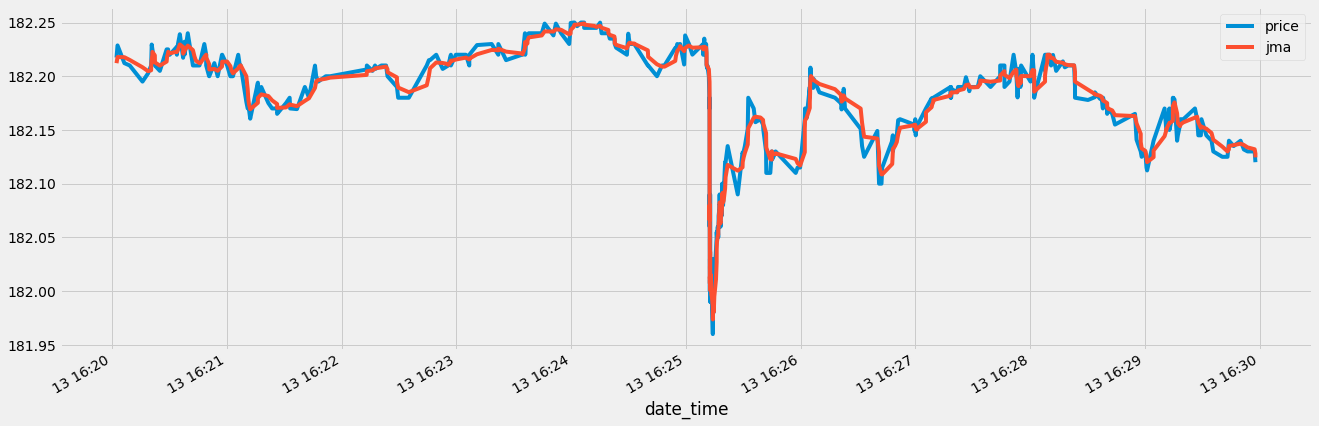

In [167]:
st = '16:20:00'
et = '16:30:00'

dfa = ticks2_df.set_index('date_time').between_time(st, et)[['price', 'jma']]
dfc = ticks2_df[ticks2_df.status=='clean'].set_index('date_time').between_time(st, et)[['price', 'jma']]

dfc[['price', 'jma']].plot()

# post-hoc JMA
# ft.jma_filter_df(dfc, col='price', length=7, power=2)[['price', 'jma']].plot()
# .plot_bokeh(sizing_mode="scale_height")

# Build Bars Workflow

In [ ]:
ray.init(ignore_reinit_error=True, num_cpus=4, dashboard_port=8080)

In [ ]:
daily_bar_stats_df, labeled_bar_dates, stacked_bars_df = bm.bars_workflow_ray(
    symbol, 
    start_date,
    end_date, 
    thresh,
)

In [ ]:
ray.shutdown()